In [1]:
import pandas as pd
from collections import Counter
import math
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import pandas as pd


c:\Users\Lasse\anaconda3\envs\bachelorproject\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load the data and create the news_id and full_text columns

In [11]:

# Load fake and real news datasets
pf_fake = pd.read_csv("../data/raw/PolitiFact_fake_news_content.csv")
pf_real = pd.read_csv("../data/raw/PolitiFact_real_news_content.csv")

# Concatenate them into a full dataset
df_full = pd.concat([pf_real, pf_fake], ignore_index=True)

# Append news_id from PolitiFactNews.txt
with open('../data/raw/PolitiFactNews.txt', 'r') as file:
    news_ids = [line.strip() for line in file]

df_full["news_id"] = news_ids

# Load train and test id's
with open('../data/processed/FakeNewsNet/trainIds.txt', 'r') as file:
    train_values = [line.strip() for line in file]
with open('../data/processed/FakeNewsNet/testIds.txt', 'r') as file:
    test_values = [line.strip() for line in file]

# Create train and test data sets
df_train = df_full[df_full['news_id'].isin(train_values)]
df_test = df_full[df_full['news_id'].isin(test_values)]

df_train["full_text"] = df_train["title"] + " " + df_train["text"]
df_test["full_text"] = df_test["title"] + " " + df_test["text"]

# Create a label column stating whether the news is fake or real based on the news_id column
df_train["label"] = df_train["news_id"].apply(lambda x: "fake" if x.split("_")[1].lower() == "fake" else "real")
df_test["label"] = df_test["news_id"].apply(lambda x: "fake" if x.split("_")[1].lower() == "fake" else "real")


C:\Users\Lasse\AppData\Local\Temp\ipykernel_30996\2085749913.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["full_text"] = df_train["title"] + " " + df_train["text"]
C:\Users\Lasse\AppData\Local\Temp\ipykernel_30996\2085749913.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["full_text"] = df_test["title"] + " " + df_test["text"]
C:\Users\Lasse\AppData\Local\Temp\ipykernel_30996\2085749913.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

## Creating a TF-IDF representation.

In [126]:
# Download the stopwords dataset
nltk.download('stopwords', quiet=True)


def tokenize(text, stemmer, stop_words):
    """Tokenize text, stem, and remove stop words."""
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [stemmer.stem(token) for token in tokens if token not in stop_words]

def compute_tfidf_train(df, column_name):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    # Tokenize, stem and compute term frequency for each document
    df['tf'] = df[column_name].apply(lambda x: Counter(tokenize(x, stemmer, stop_words)))

    # Create a list of all unique words in the corpus
    all_unique_words = list(set(word for tf in df['tf'] for word in tf.keys()))

    # Compute the number of documents in which each word appears
    word_document_count = Counter(word for tf in df['tf'] for word in tf.keys())

    # Compute the total number of documents
    total_documents = len(df)

    # Compute inverse document frequency for each word
    idf = {word: math.log(total_documents / count) for word, count in word_document_count.items()}

    # Compute TF-IDF for each word in each document and ensure that all words in the corpus are represented
    def calculate_tfidf(tf):
        return {word: tf.get(word, 0)/sum(tf.values()) * idf[word] for word in all_unique_words}

    df['tfidf'] = df['tf'].apply(calculate_tfidf)

    return df['tfidf'], all_unique_words, idf


# We create a separate function for the test data because we need to use the IDF from the training data
def compute_tfidf_test(df, column_name, train_unique_words, train_idf):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    df['tf'] = df[column_name].apply(lambda x: Counter(tokenize(x, stemmer, stop_words)))

    # Compute TF-IDF for each word in each document using the vocabulary and IDF from training data
    def calculate_tfidf(tf):
        return {word: tf.get(word, 0)/sum(tf.values()) * train_idf[word] for word in train_unique_words}

    df['tfidf'] = df['tf'].apply(calculate_tfidf)

    return df['tfidf']

# For the training data
df_train['tfidf'], train_unique_words, train_idf = compute_tfidf_train(df_train, 'full_text')

# For the test data
df_test['tfidf'] = compute_tfidf_test(df_test, 'full_text', train_unique_words, train_idf)

df_train.to_csv("../data/processed/FakeNewsNet/train.csv", index=False)
df_test.to_csv("../data/processed/FakeNewsNet/test.csv", index=False)


C:\Users\Lasse\AppData\Local\Temp\ipykernel_3736\884586417.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lasse\AppData\Local\Temp\ipykernel_3736\884586417.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lasse\AppData\Local\Temp\ipykernel_3736\884586417.py:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

## Word clouds for fake and real news

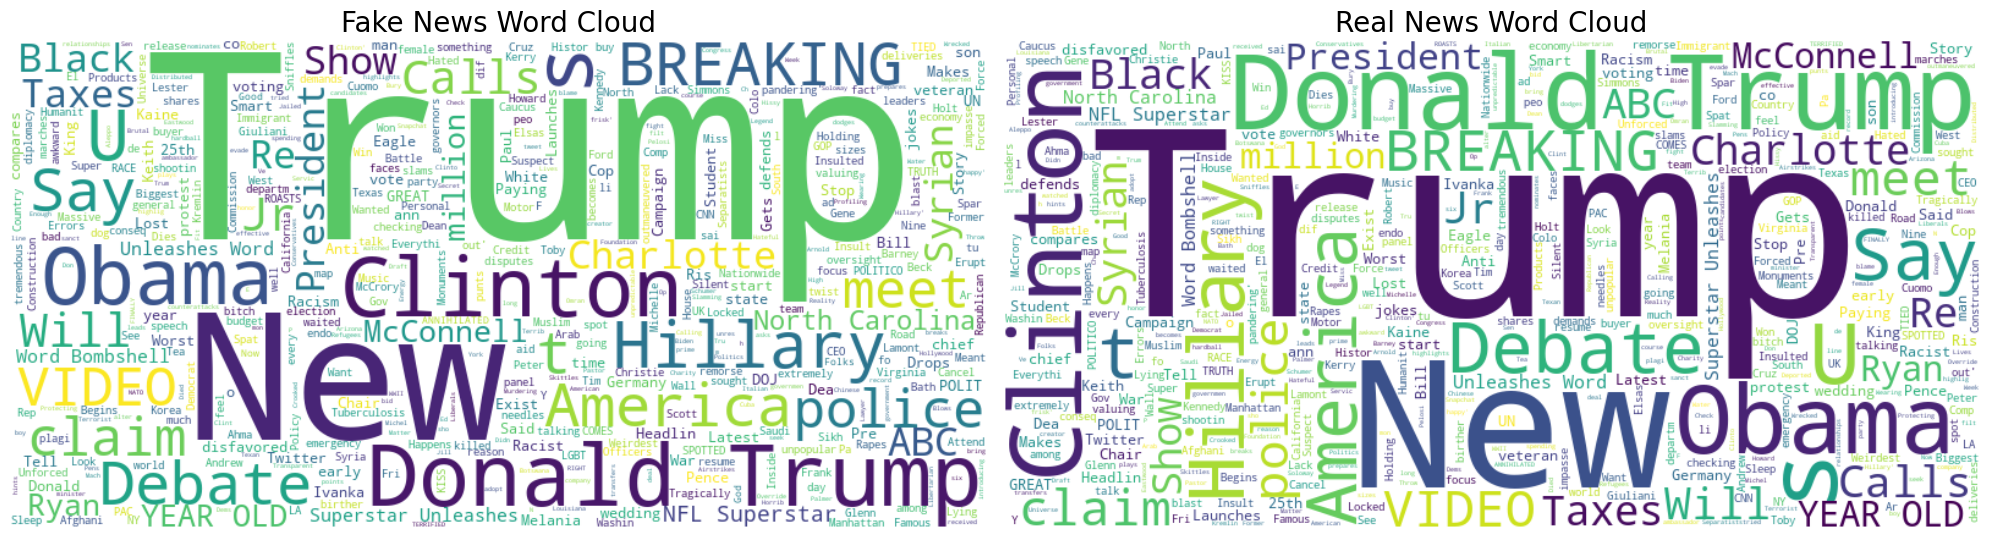

In [127]:
# Create word cloud for the fake news
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pf_fake["full_text"] = pf_fake["title"] + " " + pf_fake["text"]
pf_real["full_text"] = pf_real["title"] + " " + pf_real["text"]

# Create a word cloud for the fake news
wordcloud_fake = WordCloud(background_color="white",
                           max_words=5000,
                           contour_width=3,
                           contour_color='steelblue',
                           width=800,  
                           height=400  
                          )
wordcloud_fake.generate(pf_fake["full_text"].to_string())
wordcloud_fake.to_image()

# Create a word cloud for the real news
wordcloud_real = WordCloud(background_color="white",
                           max_words=5000,
                           contour_width=3,
                           contour_color='steelblue',
                           width=800,  
                           height=400  
                          )
wordcloud_real.generate(pf_real["full_text"].to_string())
wordcloud_real.to_image()

# Set up the figure and axes
fig, axarr = plt.subplots(1, 2, figsize=(20, 10))  # 1x2 grid of plots, adjust the figure size as needed

# Display the fake news word cloud on the left subplot
axarr[0].imshow(wordcloud_fake, interpolation='bilinear')
axarr[0].axis('off')
axarr[0].set_title("Fake News Word Cloud", fontsize=20)

# Display the real news word cloud on the right subplot
axarr[1].imshow(wordcloud_real, interpolation='bilinear')  # Make sure you're showing wordcloud_real here
axarr[1].axis('off')
axarr[1].set_title("Real News Word Cloud", fontsize=20)

# Adjust the spacing between the plots if necessary
plt.tight_layout()

plt.show()





## PCA on the training data

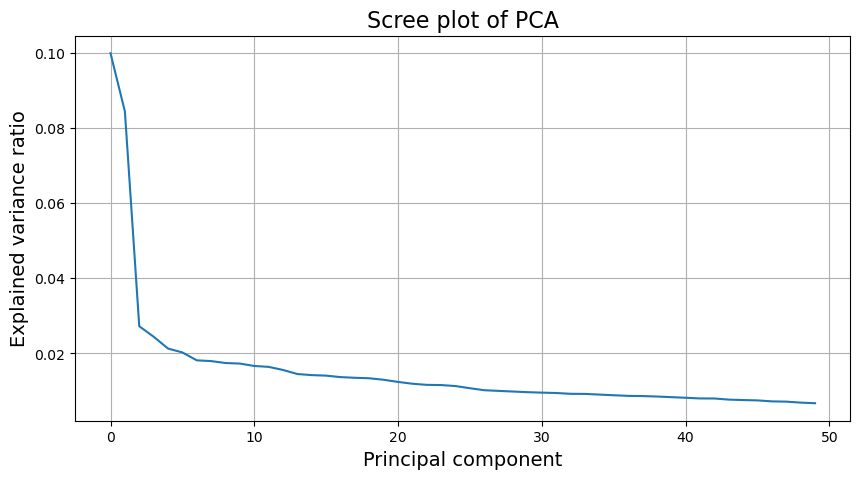

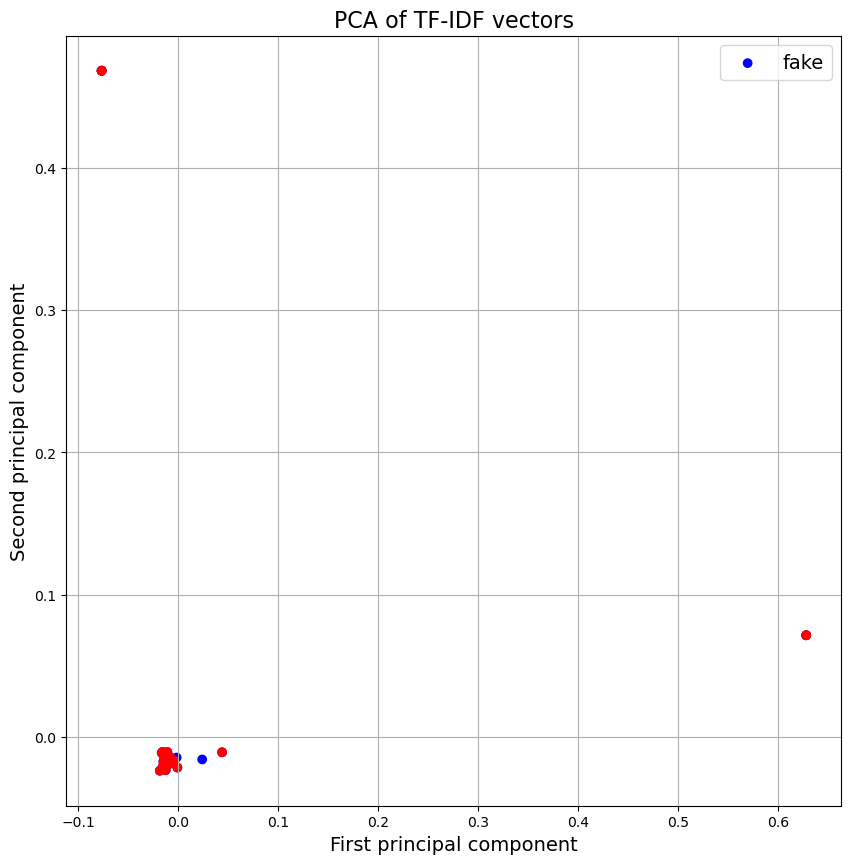

In [128]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction import DictVectorizer
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import plot

# Convert the dictionaries in the "tfidf" column into a matrix
dict_vectorizer = DictVectorizer(sparse=False)
tfidf_matrix = dict_vectorizer.fit_transform(df_train['tfidf'])

# Compute PCA of the TF-IDF vectors
pca = PCA(n_components=50)
pca.fit(tfidf_matrix)

# Transform the TF-IDF matrix using the PCA model
tfidf_pca = pca.transform(tfidf_matrix)

plt.figure(figsize=(10, 5))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal component', fontsize=14)
plt.ylabel('Explained variance ratio', fontsize=14)
plt.title('Scree plot of PCA', fontsize=16)
plt.grid(True)
plt.show()

# Create a scatter plot of the two first principal components
plt.figure(figsize=(10, 10))
plt.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], c=df_train['label'].map({'fake': 'red', 'real': 'blue'}), cmap='coolwarm')
plt.xlabel('First principal component', fontsize=14)
plt.ylabel('Second principal component', fontsize=14)
plt.title('PCA of TF-IDF vectors', fontsize=16)
plt.grid(True)
plt.legend(['fake', 'real'], fontsize=14)
plt.show()

c:\Users\Lasse\anaconda3\envs\bachelorproject\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\Lasse\anaconda3\envs\bachelorproject\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



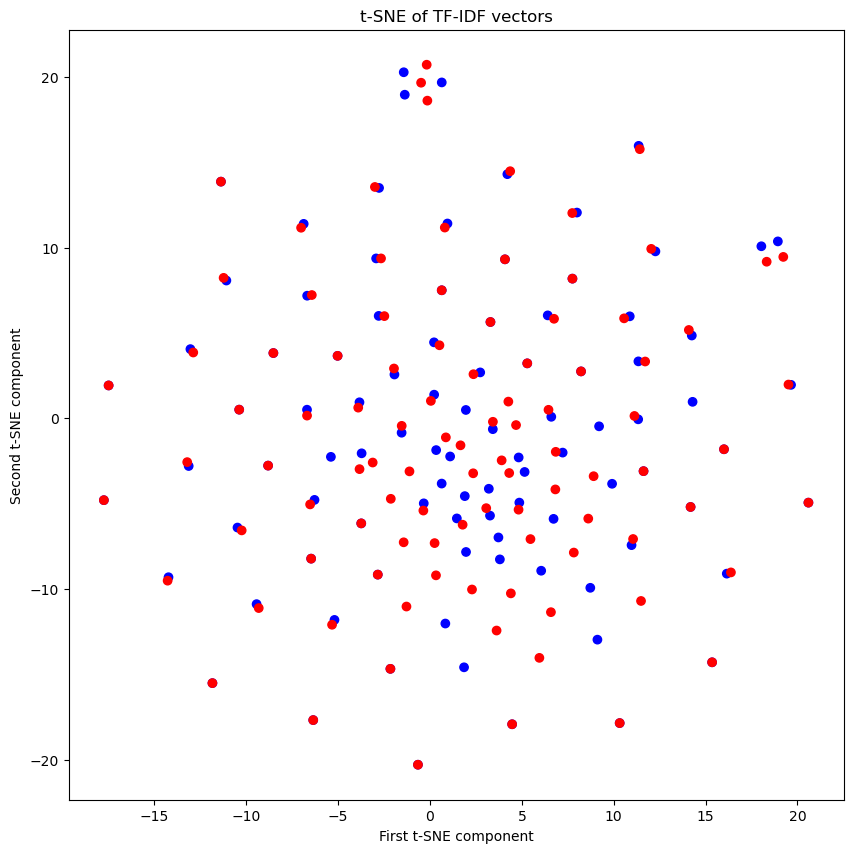

In [129]:
# Create a t-SNE scatter plot of the trainind data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Compute t-SNE of the TF-IDF vectors
tsne = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=1000)
tsne.fit(tfidf_matrix)

# Transform the TF-IDF matrix using the t-SNE model
tfidf_tsne = tsne.fit_transform(tfidf_matrix)

# Create a scatter plot of the two first t-SNE components
plt.figure(figsize=(10, 10))
plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], c=df_train['label'].map({'fake': 'red', 'real': 'blue'}))
plt.xlabel('First t-SNE component')
plt.ylabel('Second t-SNE component')
plt.title('t-SNE of TF-IDF vectors')
plt.show()


## Implementation of Davies-Bouldin score


In [ ]:
# Function to manually compute the Davies-Bouldin index

def davies_bouldin_index(X, labels):
    """Compute Davies-Bouldin index for a clustering solution.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        List of n_features-dimensional data points. Each row corresponds to a single data point.
    labels : array-like, shape (n_samples,)
        Predicted labels for each sample.
    
    Returns
    -------
    float
        Davies-Bouldin index for the clustering solution.
    
    """
    # Compute cluster centroids
    centroids = [X[labels == i].mean(axis=0) for i in range(len(set(labels)))]
    
    # Compute cluster scatter matrices
    S = [np.sum((X[labels == i] - centroids[i])**2, axis=0) for i in range(len(set(labels)))]
    
    # Compute pairwise distance between cluster centroids
    M = np.array([np.sqrt(np.sum((centroids[i] - centroids[j])**2)) for i in range(len(centroids)) for j in range(len(centroids))]).reshape(len(centroids), len(centroids))
    
    # Compute Davies-Bouldin index
    DB = np.mean([(S[i] + S[j])/M[i, j] for i in range(len(S)) for j in range(len(S)) if j != i])
    
    return DB


## k-Means clustering used for classification

In [106]:
import numpy as np
from sklearn.metrics import davies_bouldin_score
from tqdm import tqdm

# Set the maximum number of iterations
max_iterations = 100

# Set the number of data points
n = tfidf_matrix.shape[0]

# Range of k values to test
k_values = range(2, 11)  # for example, testing k from 2 to 10
db_scores = []

for k in tqdm(k_values):
    # Initialize the centroids randomly from the data points
    centroids = tfidf_matrix[np.random.randint(0, n, k)]
    
    # Initialize the membership matrix randomly
    membership = np.zeros(n)

    # Iterate until convergence or until max_iterations is reached
    for iteration in range(max_iterations):
        # Compute the distance between each data point and each centroid
        distances = np.array([np.linalg.norm(tfidf_matrix - centroid, axis=1) for centroid in centroids])

        # Assign each data point to the closest centroid
        new_membership = np.argmin(distances, axis=0)

        # If no point changed membership, stop the iteration
        if np.array_equal(membership, new_membership):
            break

        # Update the membership matrix
        membership = new_membership

        # Update the centroids
        centroids = np.array([tfidf_matrix[membership == c].mean(axis=0) for c in range(k)])
    
    # Check if there are at least two unique clusters
    if len(np.unique(membership)) > 1:
        # Compute Davies-Bouldin score
        db_score = davies_bouldin_score(tfidf_matrix, membership)
        db_scores.append(db_score)
    else:
        # If not, append a high score to indicate poor clustering
        db_scores.append(float('inf'))

# Choose the k with the lowest Davies-Bouldin score
best_k = k_values[np.argmin(db_scores)]




 44%|████▍     | 4/9 [00:00<00:00, 14.12it/s]C:\Users\Lasse\AppData\Local\Temp\ipykernel_3736\2018313091.py:38: RuntimeWarning:

Mean of empty slice.

c:\Users\Lasse\anaconda3\envs\bachelorproject\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning:

divide by zero encountered in divide

c:\Users\Lasse\anaconda3\envs\bachelorproject\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning:

invalid value encountered in divide

100%|██████████| 9/9 [00:15<00:00,  1.75s/it]

Counter({0: 173, 5: 4, 1: 2, 7: 2, 3: 2, 6: 2, 2: 2, 9: 2, 8: 2, 4: 1})
Best k value is: 2


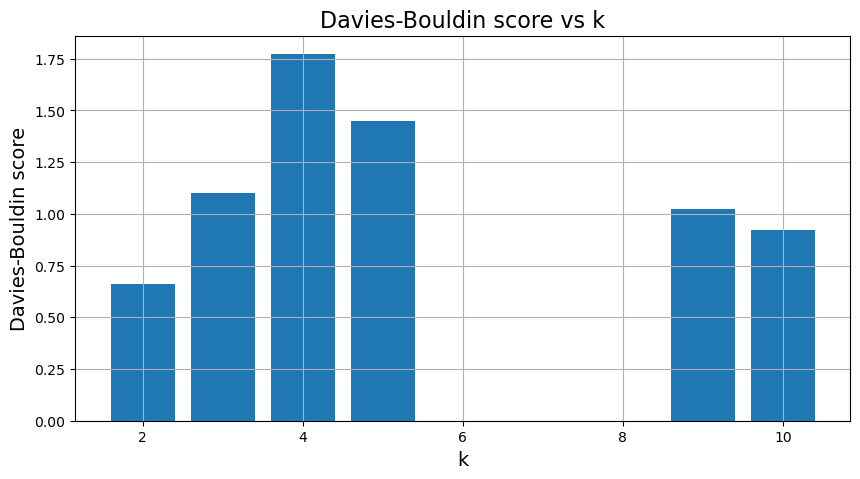

In [123]:
#Create a histogram of the Davies-Bouldin scores
plt.figure(figsize=(10, 5))
plt.bar(k_values, db_scores)
plt.xlabel('k', fontsize=14)
plt.ylabel('Davies-Bouldin score', fontsize=14)
plt.title('Davies-Bouldin score vs k', fontsize=16)
plt.grid(True)
plt.show()

In [122]:
# Use the best k value to compute the final clustering
# Initialize the centroids randomly from the data points
centroids = tfidf_matrix[np.random.randint(0, n, best_k)]

# Initialize the membership matrix randomly
membership = np.zeros(n)

# Iterate until convergence or until max_iterations is reached
for iteration in range(max_iterations):
    # Compute the distance between each data point and each centroid
    distances = np.array([np.linalg.norm(tfidf_matrix - centroid, axis=1) for centroid in centroids])

    # Assign each data point to the closest centroid
    new_membership = np.argmin(distances, axis=0)

    # If no point changed membership, stop the iteration
    if np.array_equal(membership, new_membership):
        break

    # Update the membership matrix
    membership = new_membership

    # Update the centroids
    centroids = np.array([tfidf_matrix[membership == c].mean(axis=0) for c in range(best_k)])

# Show the class distribution for the different clusters
print(Counter(membership))

Counter({0: 188, 1: 4})
